In [1]:
import os
import cv2
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set parameters
dataset_dir = 'Aerial_Landscapes'
model_dir = 'models'  # The location to save the model
os.makedirs(model_dir, exist_ok=True)

categories = ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland',
              'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']

resize_size = (256, 256)
n_clusters = 100
sift = cv2.SIFT_create()

In [3]:
# the path to save the model
kmeans_path = os.path.join(model_dir, 'kmeans_bovw.pkl')
svm_path = os.path.join(model_dir, 'svm_classifier.pkl')
label_encoder_path = os.path.join(model_dir, 'label_encoder.pkl')

In [4]:
# extract BoVW features
def extract_bow_feature(img, kmeans, sift, n_clusters):
    keypoints, descriptors = sift.detectAndCompute(img, None)
    if descriptors is None:
        return np.zeros(n_clusters)
    clusters = kmeans.predict(descriptors)
    hist, _ = np.histogram(clusters, bins=np.arange(n_clusters + 1), density=True)
    return hist

In [5]:
# load images and extract SIFT descriptors
print("Loading images and extracting SIFT descriptors...")
descriptor_list = []
image_paths = []
image_labels = []

for label in categories:
    folder_path = os.path.join(dataset_dir, label)
    for fname in os.listdir(folder_path):
        img_path = os.path.join(folder_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, resize_size)
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptor_list.extend(descriptors)
            image_paths.append(img_path)
            image_labels.append(label)

descriptor_stack = np.array(descriptor_list)

Loading images and extracting SIFT descriptors...


In [6]:
# train or load the KMeans dictionary model
if os.path.exists(kmeans_path):
    kmeans = joblib.load(kmeans_path)
else:
    print(f"Clustering {len(descriptor_stack)} descriptors into {n_clusters} visual words...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, verbose=1)
    kmeans.fit(descriptor_stack)
    joblib.dump(kmeans, kmeans_path)

In [7]:
# extract BoVW features for each image
X = []
y = []
for img_path, label in tqdm(zip(image_paths, image_labels), total=len(image_paths)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, resize_size)
    feature = extract_bow_feature(img, kmeans, sift, n_clusters)
    X.append(feature)
    y.append(label)

X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, label_encoder_path)

100%|████████████████████████████████████████████████████████████████████████████| 11921/11921 [04:58<00:00, 39.97it/s]


['models\\label_encoder.pkl']

In [8]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [9]:
# train or load the SVM classifier
if os.path.exists(svm_path):
    clf = joblib.load(svm_path)
else:
    clf = SVC(kernel='rbf', C=10, gamma='scale')
    clf.fit(X_train, y_train)
    joblib.dump(clf, svm_path)

In [10]:
# model evaluation
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.68      0.66      0.67       169
     Airport       0.61      0.65      0.63       157
       Beach       0.58      0.56      0.57       154
        City       0.67      0.74      0.70       163
      Desert       0.58      0.57      0.57       145
      Forest       0.85      0.87      0.86       156
   Grassland       0.57      0.63      0.60       162
     Highway       0.60      0.63      0.61       142
        Lake       0.49      0.40      0.44       165
    Mountain       0.77      0.81      0.79       166
     Parking       0.93      0.88      0.91       163
        Port       0.76      0.70      0.73       169
     Railway       0.66      0.70      0.68       171
 Residential       0.82      0.82      0.82       164
       River       0.41      0.36      0.38       139

    accuracy                           0.67      2385
   macro avg       0.66      0.67      0.66      2385
wei

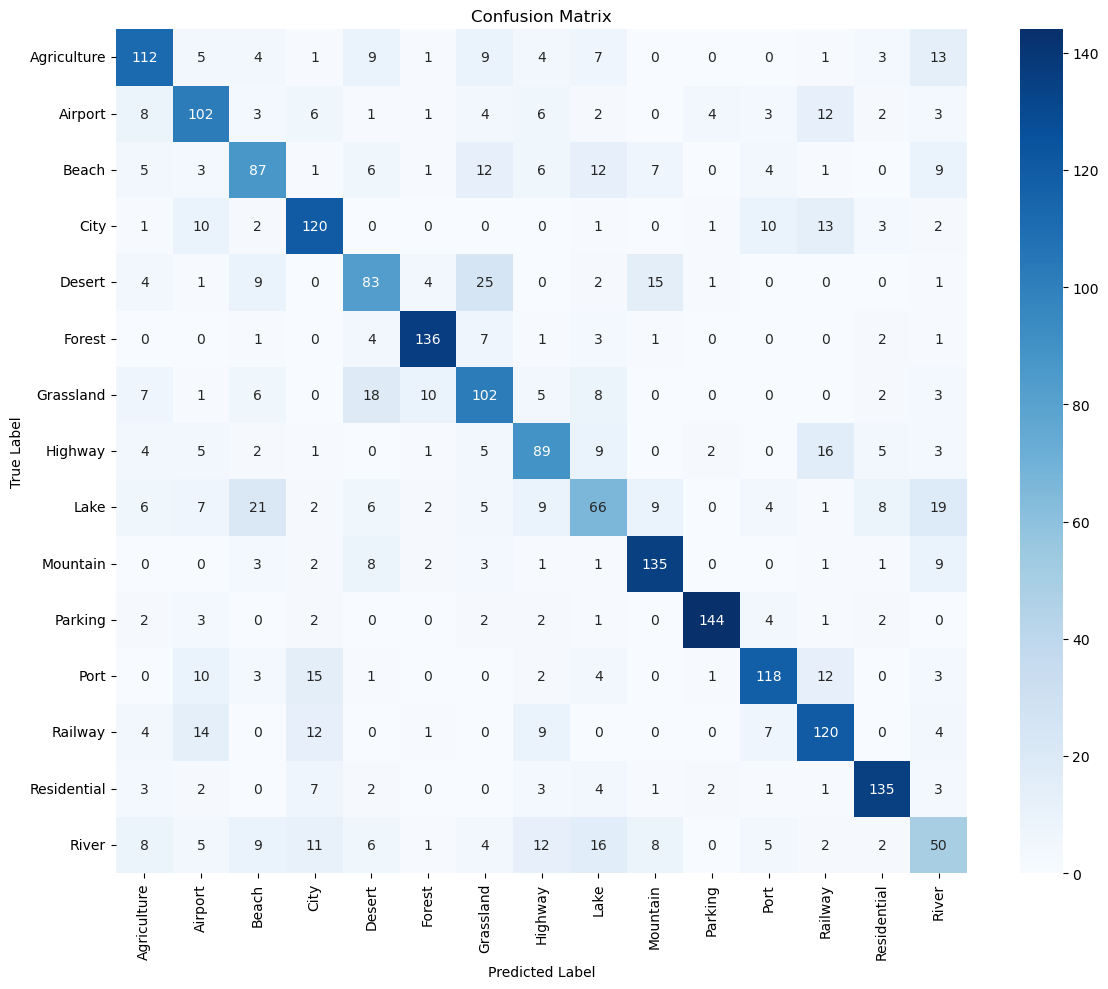

In [11]:
# confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("confusion_matrix_sift.png")
plt.show()

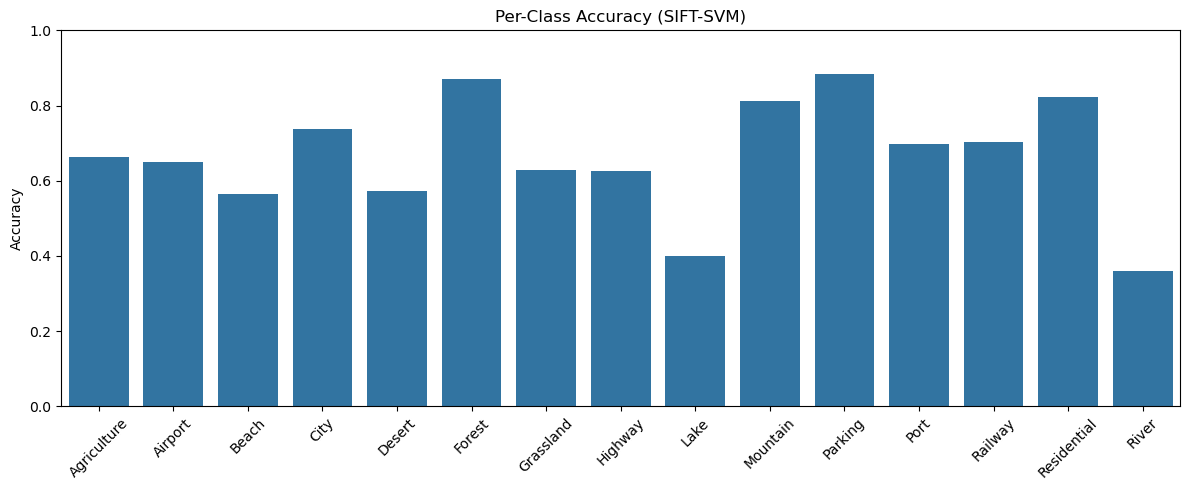

In [12]:
# per-class accuracy visualization
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 5))
sns.barplot(x=le.classes_, y=class_accuracy)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy (SIFT-SVM)")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("per_class_accuracy_sift.png")
plt.show()